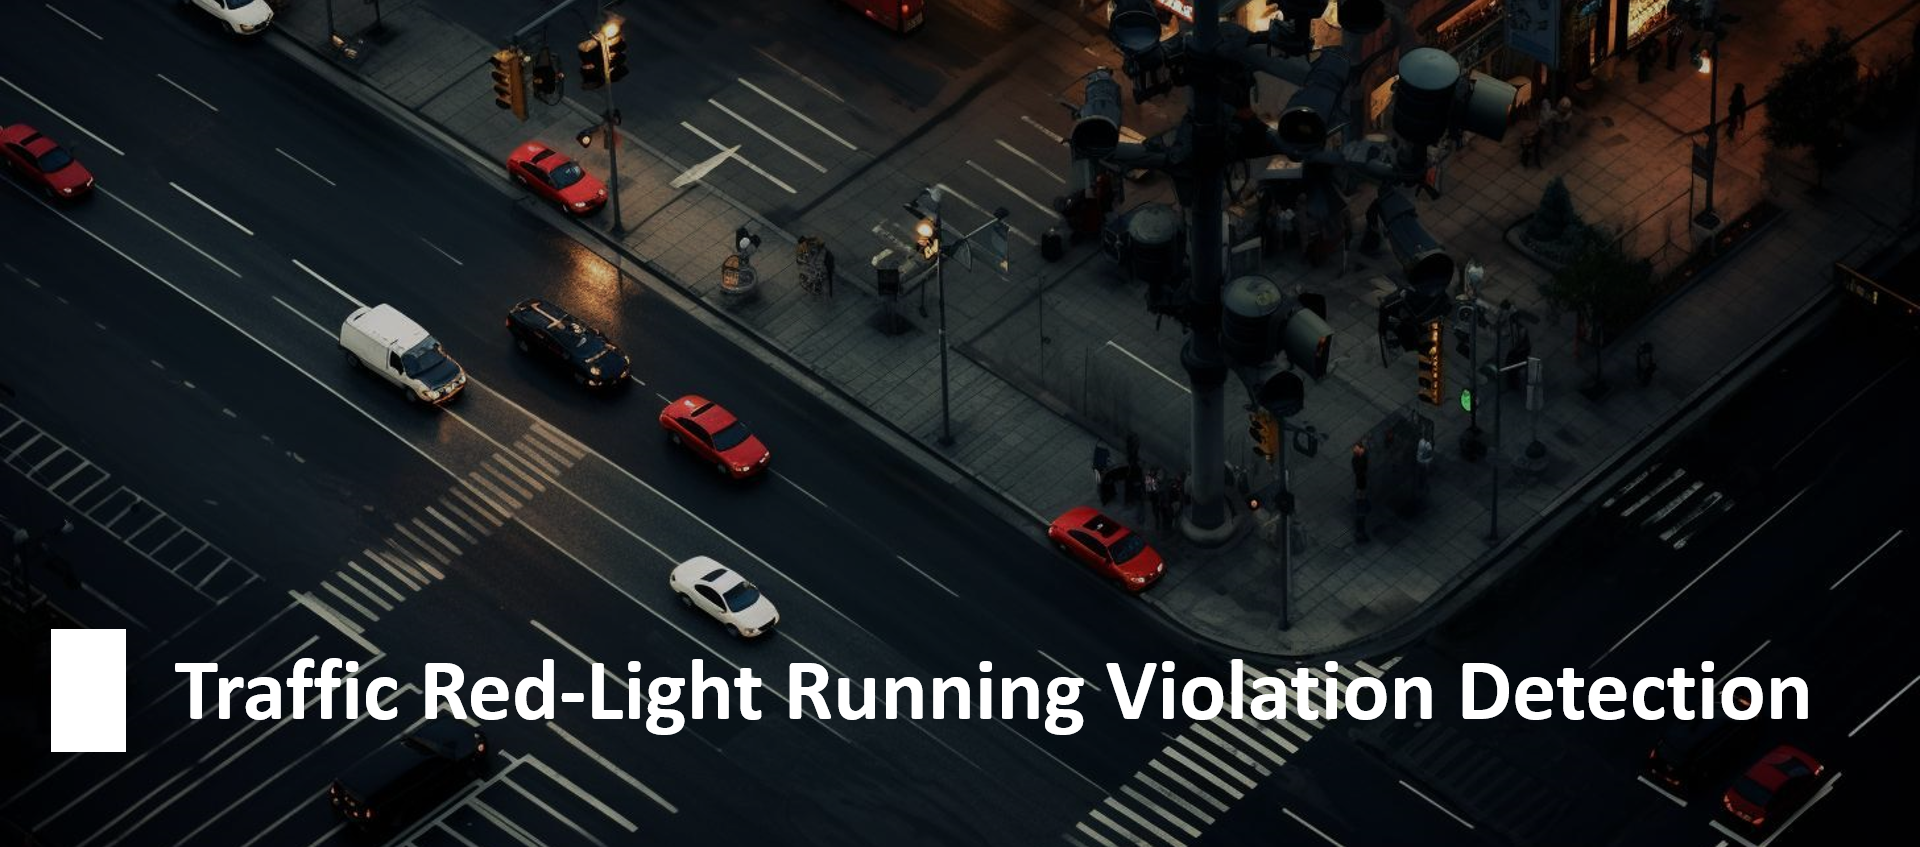

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:130%; text-align:left; color: white">
<h3 align="left"><font color=darkorange>Problem: </font></h3>
    
In urban intersections, there's a critical need for an automatic system that detects red-light running violations through real-time CCTV footage, ensuring violators are identified and fined. While deep learning approaches are often lauded, resource constraints in our scenario necessitated a pivot to classical digital image processing techniques. Despite implementing our solution on an offline video taken under the challenging conditions of nighttime, we still witness the astonishing capabilities of traditional image processing techniques in action.

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:130%; text-align:left; color: white">

<h3 align="left"><font color=darkorange>System Features: </font></h3>

    
- Non-Deep Learning Real-Time Traffic Light Color Recognition
    
    
- Adaptive and Stable Digital Image Processing Technique for Night-Time Stop Line Detection and Color-Correlation to Traffic Light Status
    
    
- Robust License Plate Extraction from Night-Time Traffic Frames using Digital Image Processing Techniques
    
    
- Text Recognition on License Plates with PyTesseract OCR
    
    
- Displaying Penalized License Plates on Video Frames with Dynamic Positioning
    
    
- Database Integration for Recording Fined License Plate Violations using MySQL

<a id="contents_tabel"></a>    
<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:130%; text-align:left; color: white">

<h3 align="left"><font color=darkorange>Table of Contents: </font></h3>
    
* <a href="#step1" style="color: white; text-decoration: none;">Step 1 | Import Necessary Libraries</a>
* <a href="#step2" style="color: white; text-decoration: none;">Step 2 | Real-Time Traffic Light Color Recognition</a>
* <a href="#step3" style="color: white; text-decoration: none;">Step 3 | Adaptive Stop Line Detection</a>
* <a href="#step4" style="color: white; text-decoration: none;">Step 4 | Robust License Plate Extraction</a>
* <a href="#step5" style="color: white; text-decoration: none;">Step 5 | Text Recognition on License Plates</a>
* <a href="#step6" style="color: white; text-decoration: none;">Step 6 | Display Penalized License Plates</a>
* <a href="#step7" style="color: white; text-decoration: none;">Step 7 | Log Fined License Plates into MySQL</a>
* <a href="#step8" style="color: white; text-decoration: none;">Step 8 | Traffic Violation Monitoring Execution</a>


<h2 align="left"><font color=#10191f>Let's get started:</font></h2>

<a id="step1"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 1 | Import Necessary Libraries</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

First of all, let's import essential libraries for our image processing, text recognition, and database connectivity tasks:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pytesseract
import easyocr
import re
import mysql.connector
import pytesseract
from PIL import Image
from collections import deque
from mysql.connector import Error

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">
    
Afterward, let's define our database connection parameters.

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">
<h3 align="left"><font color=darkorange>🔔 Instruction:</font></h3>
    
To successfully execute the subsequent sections, kindly replace the placeholders for `DB_USER` and `DB_PASSWORD` with your own database username and password, respectively.

In [2]:
# Database Connection Constants
DB_HOST = 'localhost'
DB_USER = 'your_username'
DB_PASSWORD = 'your_password'
DB_NAME = 'traffic_violations_db'

<a id="step2"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 2 |  Real-Time Traffic Light Color Recognition</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

In this section, my aim is to detect the color of a traffic light in real-time from a given frame. Here's a breakdown of the steps involved:

__1.<span style="color:darkorange"> Region of Interest (ROI)</span>__: We begin by defining a region of interest in the image. This is where we expect our traffic light to be, and we isolate this portion from the rest to focus our analysis on it.

__2.<span style="color:darkorange"> HSV Conversion</span>__: The ROI is then converted from the RGB color space to __HSV__ (Hue, Saturation, Value). HSV is often better for color-based operations since it separates the chromatic content (hue) from the luminance content.

__3.<span style="color:darkorange"> Color Range Definition</span>__: We define the range of hue values corresponding to red and yellow colors. These values are essential to detect if the traffic light is showing red, yellow, or green.

__4.<span style="color:darkorange"> Color Masks</span>__: Using the previously defined ranges, masks (binary images) are created that highlight regions in the ROI where red and yellow colors are detected.

__5.<span style="color:darkorange"> Color Recognition</span>__: We then examine the masks. If there are any non-zero values in the red mask, we deduce the light is red. If there are non-zero values in the yellow mask, the light is yellow. If neither red nor yellow is detected, we conclude the light is green.

__6.<span style="color:darkorange"> Overlay Information</span>__: Finally, we overlay a textual message on the main image indicating the detected traffic light status. This will visually inform if the signal indicates "Stop", "Caution", or "Go".

____
`detect_traffic_light_color` function enables us to automatically detect and indicate the color of traffic lights in real-time, providing vital information for further processing, especially in red-light violation detection.



In [4]:
def detect_traffic_light_color(image, rect):
    # Extract rectangle dimensions
    x, y, w, h = rect
    # Extract region of interest (ROI) from the image based on the rectangle
    roi = image[y:y+h, x:x+w]
    
    # Convert ROI to HSV color space
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define HSV range for red color
    red_lower = np.array([0, 120, 70])
    red_upper = np.array([10, 255, 255])
    
    # Define HSV range for yellow color
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])

    # Create binary masks for detecting red and yellow in the ROI
    red_mask = cv2.inRange(hsv, red_lower, red_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    
    # Font details for overlaying text on the image
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1  
    font_thickness = 2  
    
    # Check which color is present based on the masks
    if cv2.countNonZero(red_mask) > 0:
        text_color = (0, 0, 255)
        message = "Detected Signal Status: Stop"
        color = 'red'
    elif cv2.countNonZero(yellow_mask) > 0:
        text_color = (0, 255, 255)
        message = "Detected Signal Status: Caution"
        color = 'yellow'
    else:
        text_color = (0, 255, 0)
        message = "Detected Signal Status: Go"
        color = 'green'
        
    # Overlay the detected traffic light status on the main image
    cv2.putText(image, message, (15, 70), font, font_scale+0.5, text_color, font_thickness+1, cv2.LINE_AA)
    # Add a separator line
    cv2.putText(image, 34*'-', (10, 115), font, font_scale, (255,255,255), font_thickness, cv2.LINE_AA)
    
    # Return the modified image and detected color
    return image, color

<a id="step3"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 3 |  Adaptive Stop Line Detection</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

I am going to define a class in this part. My primary objective with the `LineDetector` class is to detect the stop line in the video frames. Once identified, we then aim to visually highlight the line, according to the detected traffic light status (red, yellow, or green).
    
Due to the natural phenomenon of line jittering and fluctuations across video frames, it's crucial to maintain a stable representation. This is where the concept of __<span style="color:darkorange">queues</span>__, particularly deque, comes into play. By using a deque, we can keep track of the line's positions over a set number of previous frames, helping to smoothen out abrupt changes and ensuring a more consistent visual representation.

The choice of implementing this logic within a class instead of a standalone function was essential. This decision ensures that our queues, which store the y-coordinates of the detected line's starting and ending points, persist across frames. If we had opted for a simple function, each function call would re-initialize these queues, leading to inconsistencies in line detection across frames.
    
Here's a look at its operations:

__1.<span style="color:darkorange"> Initialization</span>__: The class starts with two queues (`y_start_queue` and `y_end_queue`) that store y-coordinates of the stop line's start and end points across frames, leading to a smoother depiction.

__2.<span style="color:darkorange"> Color Code Mapping</span>__: A nested function, `get_color_code`, associates color names (red, green, yellow) with their BGR counterparts. This mapping is used to dynamically highlight the detected stop line with red, yellow, or green based on the traffic light's color, achieved by adjusting the corresponding channel color of the detected line on the original frame.

__3.<span style="color:darkorange"> Line Equations</span>__: Based on provided slope and intercept values, three line equations are formulated to focus on the segment of interest.

__4.<span style="color:darkorange"> Creating Masks</span>__: Starting with the line equations, multiple masks are generated to narrow down the area of interest. Eventually, these are combined to produce one final mask that spotlights the stop line while minimizing distractions from other elements in the frame.

__5.<span style="color:darkorange"> Image Processing</span>__: The refined mask undergoes transformations, including grayscale conversion, blurring, histogram equalization, and edge detection.

__6.<span style="color:darkorange"> Hough Line Transform</span>__: Using this critical step, the __Hough Line Transform__ is applied to detect the stop line based on the identified edges within the processed image. The parameters of the detected stop line are then accumulated in our queues.

__7.<span style="color:darkorange"> Line Drawing & Coloring</span>__: The detected line, derived from prior step, is sketched on the original frame. The traffic light's color determines its hue, altering the original frame's channels.

__8.<span style="color:darkorange"> Final Mask Creation</span>__: To conclude, a final mask is generated, turning pixels above the detected line to black. This mask serves as the second output of our method and plays a pivotal role in subsequent steps, particularly in isolating license plates of cars positioned below the line—effectively targeting vehicles that have crossed the stop line during a red light signal.
    
____
`LineDetector` class stands as a cornerstone for traffic and road-based computer vision tasks, adeptly detecting and visualizing specific lines in frames.


In [5]:
class LineDetector:
    def __init__(self, num_frames_avg=10):
        # Initialize two deque queues to hold y-coordinate values across frames
        self.y_start_queue = deque(maxlen=num_frames_avg)
        self.y_end_queue = deque(maxlen=num_frames_avg)

    
    def detect_white_line(self, frame, color, 
                          slope1=0.03, intercept1=920, slope2=0.03, intercept2=770, slope3=-0.8, intercept3=2420):
        
        # Function to map color names to BGR values
        def get_color_code(color_name):
            color_codes = {
                'red': (0, 0, 255),
                'green': (0, 255, 0),
                'yellow': (0, 255, 255)
                 }
            return color_codes.get(color_name.lower())

        frame_org = frame.copy()
        
        # Line equations for defining region of interest (ROI)
        def line1(x): return slope1 * x + intercept1
        def line2(x): return slope2 * x + intercept2
        def line3(x): return slope3 * x + intercept3

        height, width, _ = frame.shape
        
        # Create a mask to spotlight the line's desired area
        mask1 = frame.copy()
        # Set pixels below the first line to black in mask1
        for x in range(width):
            y_line = line1(x)
            mask1[int(y_line):, x] = 0

        mask2 = mask1.copy()
        # Set pixels above the second line to black in mask2
        for x in range(width):
            y_line = line2(x)
            mask2[:int(y_line), x] = 0

        mask3 = mask2.copy()
        # Set pixels to the left of the third line to black in mask3 (final mask)
        for y in range(height):
            x_line = line3(y)
            mask3[y, :int(x_line)] = 0

        # Convert the mask to grayscale
        gray = cv2.cvtColor(mask3, cv2.COLOR_BGR2GRAY)

        # Apply a Gaussian filter to the ROI
        blurred_gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # Apply CLAHE to equalize the histogram
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_clahe = clahe.apply(blurred_gray)

        # Perform edge detection
        edges = cv2.Canny(gray, 30, 100)

        # Perform a dilation and erosion to close gaps in between object edges
        dilated_edges = cv2.dilate(edges, None, iterations=1)
        edges = cv2.erode(dilated_edges, None, iterations=1)

        # Perform Hough Line Transform
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=160, maxLineGap=5)

        # Calculate x coordinates for the start and end of the line
        x_start = 0
        x_end = width - 1

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Calculate line parameters
                slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)  # Add a small number to avoid division by zero
                intercept = y1 - slope * x1

                # Calculate corresponding y coordinates
                y_start = int(slope * x_start + intercept)
                y_end = int(slope * x_end + intercept)

                # Add the y_start and y_end values to the queues
                self.y_start_queue.append(y_start)
                self.y_end_queue.append(y_end)

        # Compute the average y_start and y_end values
        avg_y_start = int(sum(self.y_start_queue) / len(self.y_start_queue)) if self.y_start_queue else 0
        avg_y_end = int(sum(self.y_end_queue) / len(self.y_end_queue)) if self.y_end_queue else 0

        
        # Draw the line
        line_start_ratio=0.32
        x_start_adj = x_start + int(line_start_ratio * (x_end - x_start))  # Adjusted x_start
        avg_y_start_adj = avg_y_start + int(line_start_ratio * (avg_y_end - avg_y_start))  # Adjusted avg_y_start

        # Create a mask with the same size as the frame and all zeros (black)
        mask = np.zeros_like(frame)

        # Draw the line on the mask
        cv2.line(mask, (x_start_adj, avg_y_start_adj), (x_end, avg_y_end), (255, 255, 255), 4)

        # Determine which color channel(s) to change based on the color argument
        color_code = get_color_code(color)
        if color_code == (0, 255, 0):  # Green
            channel_indices = [1]
        elif color_code == (0, 0, 255):  # Red
            channel_indices = [2]
        elif color_code == (0, 255, 255):  # Yellow
            # Yellow in BGR is a combination of green and red channels.
            # Here we modify both green and red channels.
            channel_indices = [1, 2]
        else:
            raise ValueError('Unsupported color')

        # Change the specified color channels of the frame where the mask is white
        for channel_index in channel_indices:
            frame[mask[:,:,channel_index] == 255, channel_index] = 255
                
                
        # Calculate slope and intercept for the average green line
        slope_avg = (avg_y_end - avg_y_start) / (x_end - x_start + np.finfo(float).eps)
        intercept_avg = avg_y_start - slope_avg * x_start

        # Create a mask with the pixels above the green line set to black
        mask_line = np.copy(frame_org)
        for x in range(width):
            y_line = slope_avg * x + intercept_avg - 35
            mask_line[:int(y_line), x] = 0  # set pixels above the line to black

        return frame, mask_line

<a id="step4"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 4 |  Robust License Plate Extraction</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

In this step, I am going to define another function. The function `extract_license_plate` is structured into several key phases to detect and extract license plates from a given frame. Here's an outline of the process:

__1.<span style="color:darkorange"> Preprocessing</span>__: The code initiates with essential preprocessing steps. This includes converting the image to grayscale to work with single-channel intensity values and applying __CLAHE__ to equalize the histogram, thereby enhancing the image contrast. Additionally, noise is minimized using erosion, paving the way for more accurate detection.

__2.<span style="color:darkorange"> Isolating and Cropping the Region of Interest (ROI)</span>__: Working on a mask from the previous steps, where pixels above the stop line are colored black, the code identifies the non-black pixels indicating the road below the stop line. It computes a bounding box around this region and then crops it, also slightly excluding a portion on the left side which belongs to the opposite lane. This focused cropped region becomes the prime ROI for the license plate detection, as __Haar cascade classifier__ performs more efficiently on smaller, well-defined ROIs.

__3.<span style="color:darkorange"> Haar Cascade Classifier</span>__: The cropped grayscale image is then passed to a Haar cascade classifier, a classic non-deep learning method adept at pattern recognition. This classifier has been pre-trained to recognize license plate patterns, and it returns the locations of potential license plates in the form of rectangles.

__4.<span style="color:darkorange"> Extracting License Plates & Final Output</span>__: The detected license plates are marked with rectangles on the original frame. Additionally, the potential license plates are cropped from the grayscale region and stored in a list. The function concludes by returning both the original frame with license plates bounded and the potential detected license plates.

___
    
`extract_license_plate` is a streamlined and well-organized function that is key for applications requiring license plate recognition. It leverages classic computer vision techniques to efficiently extract the valuable information required.

    

In [6]:
def extract_license_plate(frame, mask_line):    
    # Convert the image to grayscale (Haar cascades are typically trained on grayscale images)
    gray = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE to equalize the histogram
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Erode the image using a 2x2 kernel to remove noise
    kernel = np.ones((2, 2), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)

    # Find the bounding box of non-black pixels
    non_black_points = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(non_black_points)

    # Calculate the new width of the bounding box, excluding 30% on the right side
    w = int(w * 0.7)

    # Crop the image to the bounding box
    cropped_gray = gray[y:y+h, x:x+w]

    # Detect license plates in the image (this returns a list of rectangles)
    license_plates = license_plate_cascade.detectMultiScale(cropped_gray, scaleFactor=1.07, minNeighbors=15, minSize=(20, 20))

    # List to hold cropped license plate images
    license_plate_images = []

    # Loop over the license plates
    for (x_plate, y_plate, w_plate, h_plate) in license_plates:
        # Draw a rectangle around the license plate in the original frame (here you need the original coordinates)
        cv2.rectangle(frame, (x_plate + x, y_plate + y), (x_plate + x + w_plate, y_plate + y + h_plate), (0, 255, 0), 3)
    
        # Crop the license plate and append it to the list (here x_plate and y_plate are relative to cropped_gray)
        license_plate_image = cropped_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
        license_plate_images.append(license_plate_image)

    return frame, license_plate_images

<a id="step5"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 5 | Text Recognition on License Plates</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

I am going to define `apply_ocr_to_image` function, which is meticulously crafted to recognize and extract textual information (like numbers and characters) from given license plate images using the `PyTesseract OCR`. Here's a concise breakdown of its operations:

__<span style="color:darkorange">1. Image Thresholding</span>__: The image is thresholded, converting it into a binary format. This aids in distinguishing characters from the background, ensuring the text on the license plate is in black and the background is white.

__<span style="color:darkorange">2. Format Conversion</span>__: As PyTesseract requires the PIL Image format, the thresholded image, which is initially in OpenCV's format, is seamlessly converted to the PIL Image format to make it compatible with the OCR process.

__<span style="color:darkorange">3. Text Extraction using Classic OCR</span>__: The PyTesseract OCR tool is then used to extract text from the converted image. A special configuration (`--psm 6`) is employed to aid the OCR in recognizing sparse text on a sparse background, typical for license plates.

__<span style="color:darkorange">4. Text Cleanup</span>__: Post extraction, any extraneous white spaces that might have been appended to the start or end of the recognized text are removed to ensure the returned text is clean and compact.

____
With `apply_ocr_to_image` function in hand, applications can efficiently extract textual information from license plate images, leveraging the power of traditional machine learning techniques for OCR.


In [7]:
def apply_ocr_to_image(license_plate_image):    
    # Threshold the image
    _, img = cv2.threshold(license_plate_image, 120, 255, cv2.THRESH_BINARY)

    # Convert OpenCV image format to PIL Image format for pytesseract
    pil_img = Image.fromarray(img)

    # Use pytesseract to extract text from the image
    full_text = pytesseract.image_to_string(pil_img, config='--psm 6')

    return full_text.strip()  # Removing any extra white spaces from the ends

<a id="step6"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 6 | Display Penalized License Plates</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

The function, `draw_penalized_text`, is adeptly built to display, on the video frames, the license plates that have been penalized. This dynamic display ensures that each fined license plate is shown in the order of its identification. Whether the video feed is from offline recordings or real-time monitoring, the list of fined plates is dynamically updated on the car monitoring screen.

____
With this function, viewers can easily track and view penalized license plates in real-time on their car monitoring screens, making it an indispensable tool for any vehicle monitoring or traffic management system.



In [8]:
def draw_penalized_text(frame):
    # Set font, scale, thickness, and color
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1  
    font_thickness = 2
    color = (255, 255, 255)  # White color
    
    # Initial position for Y-coordinate
    y_pos = 180
    
    # Put title on the frame
    cv2.putText(frame, 'Fined license plates:', (25, y_pos), font, font_scale, color, font_thickness)
    
    # Update Y-coordinate position
    y_pos += 80

    # Loop through all fined license plates
    for text in penalized_texts:
        # Add fined license plate text on the frame
        cv2.putText(frame, '->  '+text, (40, y_pos), font, font_scale, color, font_thickness)
        
        # Update Y-coordinate for next license plate
        y_pos += 60

<a id="step7"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 7 | Log Fined License Plates into MySQL</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

In this section. I am going to provide a set of functions working hand in hand to integrate with a __MySQL__ database, ensuring that all fined license plates are effectively recorded. These functions offer the ability to create, update, view, and clear license plate data as needed. Let's see a comprehensive breakdown of the functions:
____
These functions collectively enable efficient and streamlined management of license plate violations, ensuring data accuracy and ease of access. Given the optional nature of some functions, developers can choose to deploy only those they find essential, depending on the application's needs.


<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">
    
1.__<span style="color:darkorange"> Database and Table Initialization ( `create_database_and_table` ):</span>__ 
- Establishes a connection to MySQL with the provided credentials.
- Creates a new database if it doesn't exist, then selects it for further operations.
- Constructs a table named `license_plates` that holds records of each license plate along with their respective violation counts.
- It's essential to note that this function may be optional once a database is set up, as there's no need to recreate the structure repeatedly.

In [9]:
def create_database_and_table(host, user, password, database):
    try:
        # Create a connection
        connection = mysql.connector.connect(
            host = host,
            user = user,
            password = password
        )
        
        if connection.is_connected():
            # Create a new database cursor
            cursor = connection.cursor()

            # Create a new database using the provided name
            cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database}")
            print(f"Database {database} created successfully!")

            # Use the newly created database
            cursor.execute(f"USE {database}")

            # Create a new table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS license_plates (
                    id INT AUTO_INCREMENT PRIMARY KEY,
                    plate_number VARCHAR(255) NOT NULL UNIQUE,
                    violation_count INT DEFAULT 1
                )
            """)
            print("Table created successfully!")

            cursor.close()

    except Error as e:
        print("Error while connecting to MySQL", e)

    finally:
        if connection.is_connected():
            connection.close()

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">
    
2.__<span style="color:darkorange"> Recording Violations: ( `update_database_with_violation` ):</span>__
- Connects to the specified MySQL database.
- Checks if a particular license plate already exists in the database.
- If the license plate exists, its violation count is incremented. If it doesn't, a new record for the license plate is added with a default violation count of 1.

In [10]:
def update_database_with_violation(plate_number, host, user, password, database):
    try:
        connection = mysql.connector.connect(
            host = host,
            user = user,
            password = password,
            database = database
        )
        
        if connection.is_connected():
            cursor = connection.cursor()

            # Check if the license plate already exists in the table
            cursor.execute(f"SELECT violation_count FROM license_plates WHERE plate_number='{plate_number}'")
            result = cursor.fetchone()
            
            if result:
                # Increment violation_count by 1 if plate_number already exists
                cursor.execute(f"UPDATE license_plates SET violation_count=violation_count+1 WHERE plate_number='{plate_number}'")
            else:
                # Insert a new record if plate_number doesn't exist
                cursor.execute(f"INSERT INTO license_plates (plate_number) VALUES ('{plate_number}')")
            
            connection.commit()
            cursor.close()

    except Error as e:
        print("Error while connecting to MySQL", e)

    finally:
        if connection.is_connected():
            connection.close()

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

3.__<span style="color:darkorange"> Viewing All Violations: ( `print_all_violations` ):</span>__
- Fetches and displays all the recorded license plate violations, ordered by the number of violations.
- This function serves as an optional utility for users/admins who wish to view a snapshot of all violations. While it might not be necessary for all use cases, it provides a quick glance at the data.

In [11]:
def print_all_violations(host, user, password, database):
    try:
        connection = mysql.connector.connect(
            host = host,
            user = user,
            password = password,
            database = database
        )
        
        if connection.is_connected():
            cursor = connection.cursor()

            # Fetch all violations from the database
            cursor.execute("SELECT plate_number, violation_count FROM license_plates ORDER BY violation_count DESC")
            result = cursor.fetchall()
            
            print("\n")
            print("-"*66)
            print("\nAll Registered Traffic Violations in the Database:\n")
            for record in result:
                print(f"Plate Number: {record[0]}, Violations: {record[1]}")
            
            cursor.close()

    except Error as e:
        print("Error while connecting to MySQL", e)

    finally:
        if connection.is_connected():
            connection.close()

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">
    
4.__<span style="color:darkorange"> Clearing Recorded Data ( `clear_license_plates` ):</span>__
- Deletes all the records in the `license_plates` table, effectively resetting the database.
- This function is also optional and can be seen as a tool for data management or debugging purposes. Routine operations might not require its use.

In [12]:
def clear_license_plates(host, user, password, database):
    try:
        connection = mysql.connector.connect(
            host = host,
            user = user,
            password = password,
            database = database
        )
        
        if connection.is_connected():
            cursor = connection.cursor()

            # Delete all records from the table
            cursor.execute("DELETE FROM license_plates")

            connection.commit()
            cursor.close()

    except Error as e:
        print("Error while connecting to MySQL", e)

    finally:
        if connection.is_connected():
            connection.close()

<a id="step8"></a>
# <p style="background-color:#10191f; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 8 | Traffic Violation Monitoring Execution</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

Finally, I am going to define the `main` function which encapsulates the whole process of detecting license plate violations in a video feed. The function operates on an offline video of traffic, identifies the license plate of vehicles crossing the line when the light is red, and then processes the violations. Here's a comprehensive breakdown of its operations:

1. __<span style="color:darkorange">Database Setup</span>__: As the function begins, it ensures that the appropriate database and table for storing license plate violations are available.

    
2. __<span style="color:darkorange">Video Feed</span>__: The function reads the offline video `traffic_video.mp4`, frame by frame, and processes each frame to detect any traffic violations.

    
3. __<span style="color:darkorange">Traffic Light Detection</span>__: The color of a traffic light for the given frame is detected using the `detect_traffic_light_color` function.

    
4. __<span style="color:darkorange">White Line Detection</span>__: The function calls upon the `LineDetector` class to pinpoint the white stop line on the road, highlighting it based on the detected traffic light color.

    
5. __<span style="color:darkorange">Violation Detection & Processing</span>__: If the detected color is red, the program uses the `extract_license_plate` and `apply_ocr_to_image` functions to identify vehicles crossing the white line and then to extract and read their license plates. Due to potential low-quality images fed to the `apply_ocr_to_image` function, some license plate readings may be incorrect. To counteract this, plates are verified against a predefined format, ensuring they match the standard format of a car license plate in the video. Only those that match and haven't been previously logged are recorded as violations.

    
6. __<span style="color:darkorange">Database Update</span>__: The detected and processed license plates are recorded in the database. If a plate had a previous violation, its count is incremented.

    
7. __<span style="color:darkorange">Display Updates</span>__: The `draw_penalized_text` function is called, which displays license plates that have been penalized in order on the frame.

    
8. __<span style="color:darkorange">Termination</span>__: Processing continues until the video feed concludes or until the user terminates with the ESC key. The video is then released, and all GUI windows close.

    
9. __<span style="color:darkorange">Report Generation</span>__: Finally, the function fetches and lists all violations from the database, providing an overview of all infringements during the video's duration.

____
With this approach, the `main` function offers a robust and comprehensive solution to monitor and record traffic violations from a video source, marking its significance in traffic law enforcement and analytics.


In [13]:
def main():
    # Ensure the database and table exist
    create_database_and_table(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)

    # Clear the license plates from the previous run. (Comment out this line if desired!)
    clear_license_plates(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)

    # Open the video file
    vid = cv2.VideoCapture('traffic_video.mp4')
    
    # Create detector object
    detector = LineDetector()

    # Loop through each frame in the video
    while True:
        # Read frame
        ret, frame = vid.read()
        
        # Break if frame is not returned
        if not ret:
            break

        # Assuming rect is the rectangle where the traffic light is located
        rect = (1700, 40, 100, 250) 
        
        # Detect traffic light color
        frame, color = detect_traffic_light_color(frame, rect)
        
        # Detect white line
        frame, mask_line = detector.detect_white_line(frame, color)
        
        # Process the frame if the light is red
        if color == 'red':
            # Extract license plate
            frame, license_plate_images = extract_license_plate(frame, mask_line)
            
            # Process each detected license plate
            for license_plate_image in license_plate_images:
                # Apply OCR to the license plate image
                text = apply_ocr_to_image(license_plate_image)
                
                # Add the detected license plate to the list if it matches the pattern and is not already in the list
                if text is not None and re.match("^[A-Z]{2}\s[0-9]{3,4}$", text) and text not in penalized_texts:
                    penalized_texts.append(text)
                    print(f"\nFined license plate: {text}")

                    # Plot the license plate image
                    plt.figure()
                    plt.imshow(license_plate_image, cmap='gray')
                    plt.axis('off')
                    plt.show()
                    
                    # Update the database with the license plate violation
                    update_database_with_violation(text, DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)
        
        # Draw the penalized text onto the frame if there is any
        if penalized_texts:
            draw_penalized_text(frame)

        # Display the frame
        cv2.imshow('frame', frame)

        # Break if ESC key is pressed
        if cv2.waitKey(1) == 27:
            break

    # Release the video
    vid.release()
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

    # Print all the violations from the database
    print_all_violations(DB_HOST, DB_USER, DB_PASSWORD, DB_NAME)

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

Before diving into the primary operations of our program, a few preparatory steps are crucial:

1.__<span style="color:darkorange"> Haar Cascade Initialization</span>__: A cornerstone to our license plate detection mechanism, we employ a Haar cascade classifier. This is loaded with a pre-trained model, `haarcascade_russian_plate_number.xml`, designed specifically for detecting license plates. This model is pivotal for detecting license plates in our video frames. Notably, the reason for creating this Haar cascade object outside its corresponding function is efficiency. Establishing its object from the configuration file can be time-consuming. By defining it here, we ensure our program remains agile and doesn't incur unnecessary delays every time a license plate detection is requested.

2.__<span style="color:darkorange"> Creation of List</span>__: Next up, we initialize a list named `penalized_texts`. This list acts as a repository, storing the texts of license plates that have violated traffic rules. We define this list globally so that both the `main` function and the `draw_penalized_text` function can access and modify its contents seamlessly.


In [14]:
%%capture
# Load the trained Haar Cascade
license_plate_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

# Create a list to store unique penalized license plate texts
penalized_texts = []

<div style="border-radius:10px; padding: 15px; background-color: #10191f; font-size:115%; text-align:left; color: white">

When we start the program, we use a specific line to kick things off:

__<span style="color:darkorange">Launching the Main Program</span>__: Encapsulated under the familiar Python construct `if __name__ == "__main__":`, this mechanism ensures that our `main` function springs into action only when our script is executed as a standalone entity, and not when it's imported as a module in another script. Once initiated, the `main` function commences its elaborate process – it delves into the video, discerns license plate violations, and meticulously logs any transgressions.

____
Employing this precise structure, our code remains modular and systematic, ensuring that each part runs in its rightful context, preserving the integrity and efficiency of our program.



Database traffic_violations_db created successfully!
Table created successfully!

Fined license plate: YB 6433


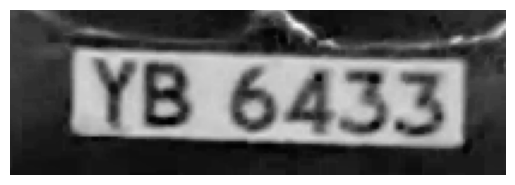


Fined license plate: NN 773


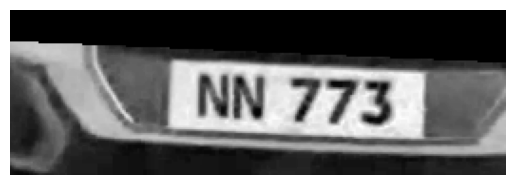



------------------------------------------------------------------

All Registered Traffic Violations in the Database:

Plate Number: YB 6433, Violations: 1
Plate Number: NN 773, Violations: 1


In [15]:
if __name__ == "__main__":
    main()

<h2 align="left"><font color=#10191f>Best Regards!</font></h2>